In [1]:
import xarray as xr
import rioxarray as rxr
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [40]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary_4326 = ucrb_boundary.copy()
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_boundaries=hcdn_boundaries.to_crs(lcc_proj)

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


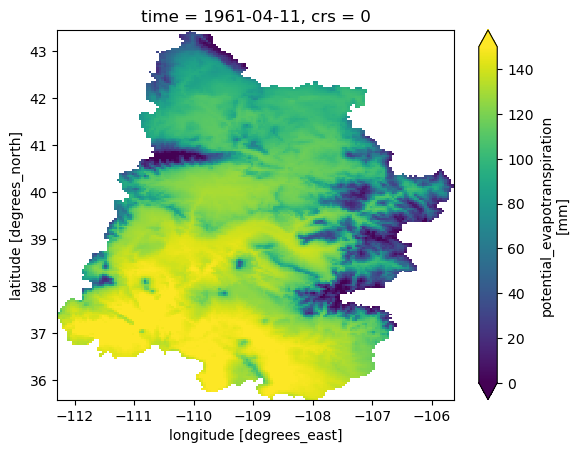

In [58]:
terraclimate_pet = xr.open_dataset('../data/etdata/TerraClimate19812010_pet.nc')
# resample to daily data
terraclimate_pet_daily = terraclimate_pet.resample(time='1D').interpolate('cubic')
# convert to a raster and change crs to match the UCRB boundary
terraclimate_pet_daily = terraclimate_pet_daily.rio.write_crs(4326)
terraclimate_pet_daily.rio.clip(ucrb_boundary_4326.geometry).isel(time=100).pet.plot(vmin=0, vmax=150)

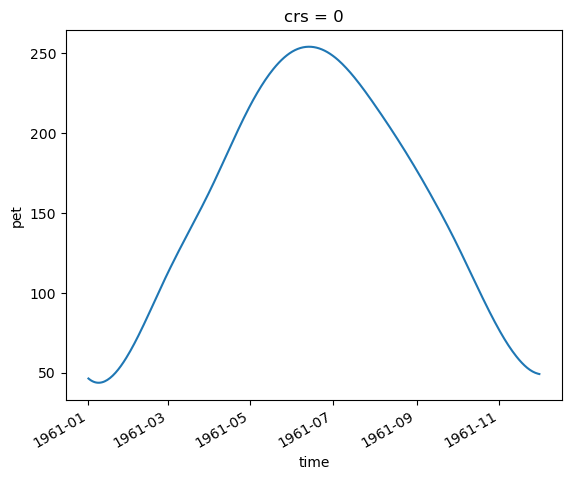

In [4]:
pet_ds = rxr.open_rasterio('../data/etdata/pevap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
et_ds = rxr.open_rasterio('../data/etdata/evap.mon.mean.nc')[0].drop(['lat','lon','spatial_ref', 'Lambert_Conformal'])
et_ds=et_ds.rio.write_crs(lcc_proj)
pet_ds = pet_ds.rio.write_crs(lcc_proj)

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/rioxarray/_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, 

In [5]:
pet_ds_clipped_ucrb = pet_ds.rio.clip(ucrb_boundary.geometry)
pet_ds_masked_ucrb=pet_ds_clipped_ucrb.where(pet_ds_clipped_ucrb['pevap']!=9.96921e+36)

# convert to mm equivalent
pet_ds_masked_ucrb['pevap'] = pet_ds_masked_ucrb['pevap']*30
pet_ds_masked_ucrb['pevap'].attrs['units']='mm'

# dx = 32462.98850575/32.46298850575
# lon = np.arange(pet_ds_masked_ucrb.x.min(), pet_ds_masked_ucrb.x.max(),dx)
# lat = np.arange(pet_ds_masked_ucrb.y.min(), pet_ds_masked_ucrb.y.max(),dx)
# pet_ds_masked_ucrb=pet_ds_masked_ucrb.interp(x=lon, y=lat, method='linear')
# PET for UCRB as a whole
pet_ds_masked_ucrb['WY'] = pet_ds_masked_ucrb.time.dt.year.where(pet_ds_masked_ucrb.time.dt.month<10,pet_ds_masked_ucrb.time.dt.year+1)
pet_wy_ds_mean_ucrb = pet_ds_masked_ucrb.where(~pet_ds_masked_ucrb['WY'].isin([1979,2023, 2016])).groupby('WY').sum().mean(dim='x').mean(dim='y')
norm_pet_ds_ucrb = ((pet_wy_ds_mean_ucrb-pet_wy_ds_mean_ucrb.mean(dim='WY'))/pet_wy_ds_mean_ucrb.std(dim='WY'))['pevap']

In [6]:
et_ds_clipped_ucrb = et_ds.rio.clip(ucrb_boundary.geometry)
et_ds_masked_ucrb=et_ds_clipped_ucrb.where(et_ds_clipped_ucrb['evap']!=9.96921e+36)

# convert to mm equivalent
et_ds_masked_ucrb['evap'] = et_ds_masked_ucrb['evap']*1000
et_ds_masked_ucrb['evap'].attrs['units']='mm'

# dx = 32462.98850575/32.46298850575
# lon = np.arange(et_ds_masked_ucrb.x.min(), et_ds_masked_ucrb.x.max(),dx)
# lat = np.arange(et_ds_masked_ucrb.y.min(), et_ds_masked_ucrb.y.max(),dx)
# et_ds_masked_ucrb=et_ds_masked_ucrb.interp(x=lon, y=lat, method='linear')
# et for UCRB as a whole
et_ds_masked_ucrb['WY'] = et_ds_masked_ucrb.time.dt.year.where(et_ds_masked_ucrb.time.dt.month<10,et_ds_masked_ucrb.time.dt.year+1)
# et_wy_ds_mean_ucrb = et_ds_masked_ucrb.where(~et_ds_masked_ucrb['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim=['x','y'])
# norm_et_ds_ucrb = ((et_wy_ds_mean_ucrb-et_wy_ds_mean_ucrb.mean(dim='WY'))/et_wy_ds_mean_ucrb.std(dim='WY'))['evap']

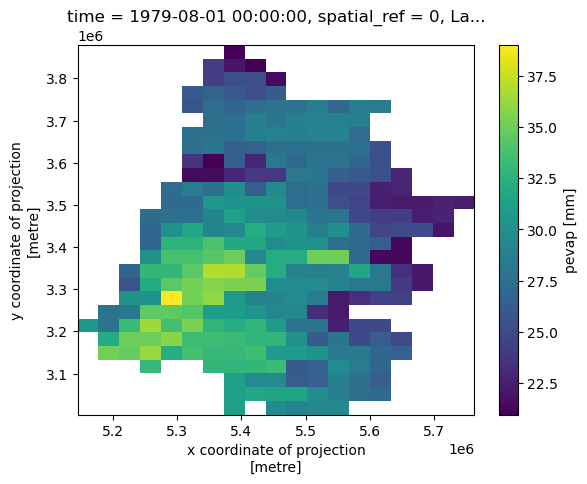

In [30]:
# import resampling
from rasterio.enums import Resampling
# pet_ds_clipped_ucrb_rpj = pet_ds_masked_ucrb.rio.reproject(dst_crs=32613, resampling=Resampling.nearest)
# pet_ds_clipped_ucrb_rpj = pet_ds_clipped_ucrb_rpj.where(pet_ds_clipped_ucrb_rpj < 1000)
pet_ds_masked_ucrb.pevap.isel(time=7).plot()

In [128]:
hcdn_et = et_ds_masked_ucrb.rio.write_crs(32613).rio.clip(hcdn_boundaries.geometry)
hcdn_et['evap'] = hcdn_et['evap']
southern_ma = (hcdn_et['y']<3.27e6) & (hcdn_et['x']<5.6e6) 
southern_et = hcdn_et.where((~hcdn_et['WY'].isin([1979,2023, 2016])) & (southern_ma)).mean(dim=['x','y']).groupby('WY').sum()['evap'] 
northern_ma = (hcdn_et['y']>3.45e6) & (hcdn_et['x']>5.55e6) 
northern_et = hcdn_et.where((~hcdn_et['WY'].isin([1979,2023, 2016])) & (northern_ma)).mean(dim=['x','y']).groupby('WY').sum()['evap']

In [129]:
et_df = pd.DataFrame({'southern':southern_et.values,
            'northern':northern_et.values}, index=southern_et.WY)
et_df.to_csv('./basin_characteristics/et_table.csv')        

In [87]:
hcdn_et.where((~hcdn_et['WY'].isin([1979,2023, 2016]))).mean(dim=['x','y']).groupby('WY').sum()/2


<xarray.Dataset>
Dimensions:            (WY: 42)
Coordinates:
  * WY                 (WY) float64 1.98e+03 1.981e+03 ... 2.021e+03 2.022e+03
    Lambert_Conformal  int32 0
    spatial_ref        int32 0
Data variables:
    evap               (WY) float32 519.2 485.0 504.3 ... 549.5 560.1 578.3

In [204]:
pet_hcdn_ds = et_ds_masked_ucrb.rio.write_crs(lcc_proj)
pet_ds_clipped = pet_hcdn_ds.rio.clip(hcdn_boundaries.geometry)
pet_ds_masked=pet_ds_clipped.where(pet_ds_clipped['evap']!=9.96921e+36)

# pet_ds_masked=pet_ds_masked.interp(x=lon, y=lat,)
# convert to mm equivalent
pet_ds_masked['evap'] = pet_ds_masked['evap']
pet_ds_masked['evap'].attrs['units']='mm'

pet_ds_masked['WY'] = pet_ds_masked.time.dt.year.where(pet_ds_masked.time.dt.month<10,pet_ds_masked.time.dt.year+1)
pet_wy_ds_mean = pet_ds_masked.where(~pet_ds_masked['WY'].isin([1979,2023,2017])).groupby('WY').sum().mean(dim='x').mean(dim='y') * 1000
norm_pet_ds = ((pet_wy_ds_mean-pet_wy_ds_mean.mean(dim='WY'))/pet_wy_ds_mean.std(dim='WY'))['evap']

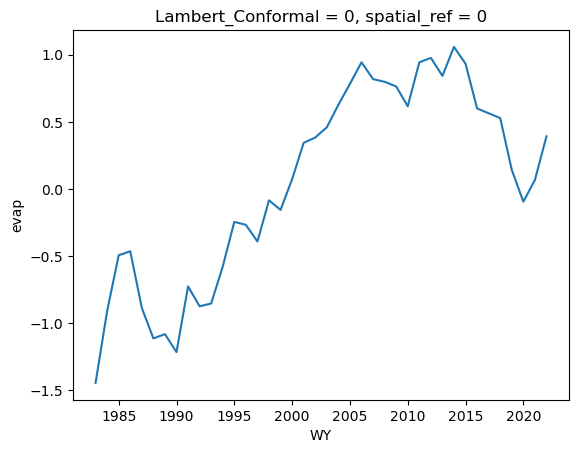

In [211]:
norm_pet_ds.rolling(WY=4).mean().plot()

In [161]:
lcc_proj = "+proj=lcc +lat_0=50 +lon_0=-107 +lat_1=50 +lat_2=50 +x_0=5632642.22547 +y_0=4612545.65137 +datum=WGS84 +units=m +no_defs" #my custom CRS
ucrb_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary=ucrb_boundary.to_crs(lcc_proj)

hcdn_boundaries = gpd.read_file('./ucrb_hcdn_co_polygons_final.json')
hcdn_boundaries=hcdn_boundaries.to_crs(lcc_proj)

### Building PET anomalies across basin cells

In [163]:
idx = [1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
       1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
       2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
       2010,2011,2012,2013,2014,2015,2016,2018,2019,
       2020,2021,2022]

df = pet_ds_masked_ucrb.where(pet_ds_masked_ucrb['WY'].isin(idx)).groupby('WY').sum().to_dataframe().reset_index()
pet_gdf = gpd.GeoDataFrame(df[df['pevap']>0][['WY','pevap']], geometry=gpd.points_from_xy(x=df[df['pevap']>0].x,y=df[df['pevap']>0].y))
pet_gdf['point'] = 0
cnt=0
for pt in et_gdf.geometry.unique():
    pet_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
    cnt+=1

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_40488\1801964380.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pet_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_40488\1801964380.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pet_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_40488\1801964380.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [164]:
idx = [1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
       1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
       2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
       2010,2011,2012,2013,2014,2015,2016,2018,2019,
       2020,2021,2022]

df = et_ds_masked_ucrb.where(et_ds_masked_ucrb['WY'].isin(idx)).groupby('WY').sum().to_dataframe().reset_index()
et_gdf = gpd.GeoDataFrame(df[df['evap']>0][['WY','evap']], geometry=gpd.points_from_xy(x=df[df['evap']>0].x,y=df[df['evap']>0].y))
et_gdf['point'] = 0
cnt=0
for pt in et_gdf.geometry.unique():
    et_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
    cnt+=1

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_40488\3821785265.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_40488\3821785265.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et_gdf.loc[:,'point'][et_gdf['geometry']==pt] = cnt
C:\Users\dlhogan\AppData\Local\Temp\ipykernel_40488\3821785265.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [179]:
pet_gdf_mean = pet_gdf.dissolve(by='point',aggfunc='mean')['pevap']
pet_gdf_std = pet_gdf.dissolve(by='point',aggfunc='std')['pevap']

pet_anom = []

for pet in pet_gdf['point'].unique():
    norm_pet_gdf = (pet_gdf[pet_gdf['point']==pt]['pevap'] - pet_gdf_mean.loc[pet])/pet_gdf_std.loc[pet]
    norm_pet_gdf.index = idx
    norm_pet_gdf.name=pet
    pet_anom.append(norm_pet_gdf)
pet_point_df_hcdn = pd.DataFrame(pet_anom).T
pet_point_df_hcdn.sample(25, axis=1).to_csv('./HCDN_PET_ANOMALY_POINTS.csv')

In [180]:
et_gdf_mean = et_gdf.dissolve(by='point',aggfunc='mean')['evap']
et_gdf_std = et_gdf.dissolve(by='point',aggfunc='std')['evap']

et_anom = []

for et in et_gdf['point'].unique():
    norm_et_gdf = (et_gdf[et_gdf['point']==et]['evap'] - et_gdf_mean.loc[et])/et_gdf_std.loc[et]
    norm_et_gdf.index = idx
    norm_et_gdf.name=pt
    et_anom.append(norm_et_gdf)
et_point_df_hcdn = pd.DataFrame(et_anom).T
et_point_df_hcdn.sample(25, axis=1).to_csv('./HCDN_ET_ANOMALY_POINTS.csv')

In [182]:
# East river 1km WRF ET
east_et_df = pd.read_csv('../../data/wrf_stand_anom_et_east.csv', sep='\t', header=None, index_col=0, names=['ET_rate'])

taylor_et_df = pd.read_csv('../../data/wrf_stand_anom_et_taylor.csv', sep='\t', header=None, index_col=0, names=['ET_rate'])
norm_prism_precip = pd.read_csv('./UCRB_HCDN_CO_PRISM_ANNUAL_PRECIP.csv', index_col='WY')

(-1.5, 1.5)

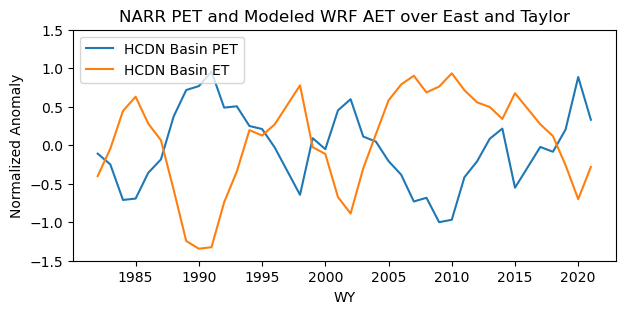

In [183]:
fig, ax = plt.subplots(figsize=(7,3))
norm_pet_ds_ucrb.rolling(WY=4, center=True).mean().plot(ax=ax, label='HCDN Basin PET')
norm_et_ds_ucrb.rolling(WY=4, center=True).mean().plot(ax=ax, label='HCDN Basin ET')
# (norm_pet_ds_ucrb).rolling(WY=4, center=False).mean().plot(ax=ax, label='UCRB Average PET')
# norm_prism_precip.mean(axis=1).rolling(4).mean().plot(ax=ax, lw=2, color='k', label=' Precipitation Anomaly across HCDN Basins')
# (taylor_et_df['ET_rate']).rolling(4, center=False).mean().plot(ax=ax, label='WRF 1KM AET Taylor')
# (east_et_df['ET_rate']).rolling(4, center=False).mean().plot(ax=ax, label='WRF 1KM AET East')
ax.legend()
ax.set_title('NARR PET and Modeled WRF AET over East and Taylor')
ax.set_ylabel('Normalized Anomaly')
ax.set_ylim(-1.5,1.5)

### Same plot but for spring PET and ET

Text(0, 0.5, 'evaporation/Potential ET Anomaly')

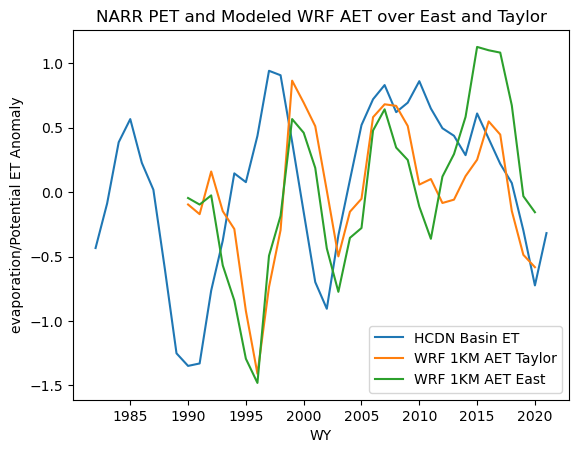

In [213]:
# # PET for HCDN Boundaries
# pet_ds_masked['WY'] = pet_ds_masked.time.dt.year.where(pet_ds_masked.time.dt.month<10,pet_ds_masked.time.dt.year+1)
# pet_ds_masked = pet_ds_masked.where(pet_ds_masked.time.dt.month.isin([4,5,6]))
# pet_wy_ds_mean = pet_ds_masked.where(~pet_ds_masked['WY'].isin([1979,2023])).groupby('WY').mean().mean(dim='x').mean(dim='y')
# norm_pet_ds = ((pet_wy_ds_mean-pet_wy_ds_mean.mean(dim='WY'))/pet_wy_ds_mean.std(dim='WY'))['pevap']

# # PET for UCRB as a whole
# pet_ds_masked_ucrb['WY'] = pet_ds_masked_ucrb.time.dt.year.where(pet_ds_masked_ucrb.time.dt.month<10,pet_ds_masked_ucrb.time.dt.year+1)
# pet_ds_masked_ucrb = pet_ds_masked_ucrb.where(pet_ds_masked_ucrb.time.dt.month.isin([4,5,6]))
# pet_wy_ds_mean_ucrb = pet_ds_masked_ucrb.where(~pet_ds_masked_ucrb['WY'].isin([1979,2023])).groupby('WY').sum().mean(dim='x').mean(dim='y')
# norm_pet_ds_ucrb = ((pet_wy_ds_mean_ucrb-pet_wy_ds_mean_ucrb.mean(dim='WY'))/pet_wy_ds_mean_ucrb.std(dim='WY'))['pevap']

fig, ax = plt.subplots()
# norm_pet_ds.plot(ax=ax, label='HCDN Basin PET')
# norm_pet_ds_ucrb.plot(ax=ax, label='UCRB Average PET')
(taylor_et_df['ET_rate']).rolling(4).mean().plot(ax=ax, label='WRF 1KM AET Taylor')
(east_et_df['ET_rate']).rolling(4).mean().plot(ax=ax, label='WRF 1KM AET East')
ax.legend()
ax.set_title('NARR PET and Modeled WRF AET over East and Taylor')
ax.set_ylabel('evaporation/Potential ET Anomaly')

In [29]:
import seaborn as sns
from scipy.stats import pearsonr

0.36182290727640276
0.045488923784927665
0.3110854314208841
0.08848713818075814
0.7519623362753933
1.0769882714481496e-06


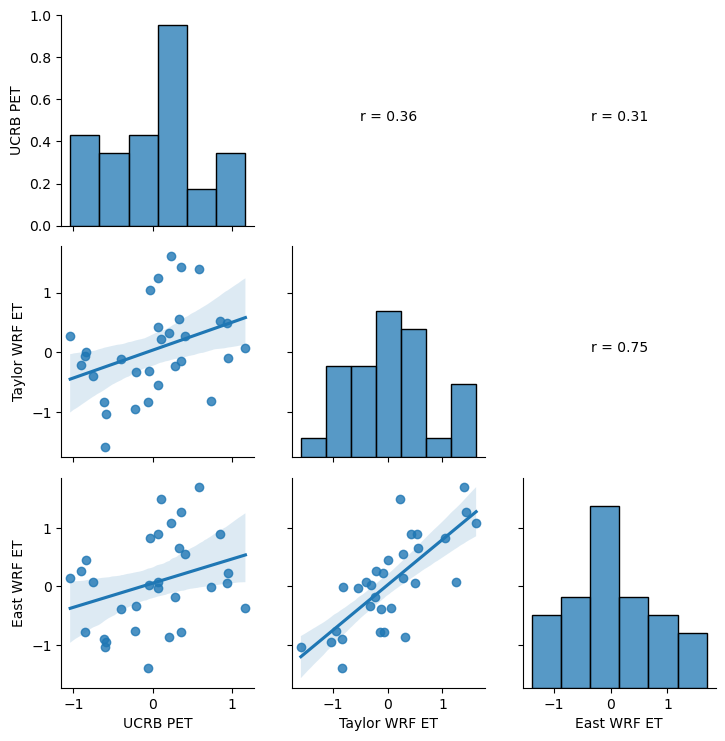

In [50]:
corr_df = pd.DataFrame([#norm_pet_ds.rolling(WY=3).mean().to_dataframe().rename(columns={'pevap':'HCDN PET'})['HCDN PET'],
              norm_pet_ds_ucrb.rolling(WY=3).mean().to_dataframe().rename(columns={'pevap':'UCRB PET'})['UCRB PET'],
              -taylor_et_df.rolling(2).mean().rename(columns={'ET_rate':'Taylor WRF ET'})['Taylor WRF ET'],
              -east_et_df.rolling(2).mean().rename(columns={'ET_rate':'East WRF ET'})['East WRF ET']]).T.dropna()
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    print(r)
    print(p)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(corr_df)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)